<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Обзор-данных-и-их-подготовка" data-toc-modified-id="Обзор-данных-и-их-подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных и их подготовка</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Моделирование</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Проверка-качества" data-toc-modified-id="Проверка-качества-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка качества</a></span></li><li><span><a href="#Проверка-на-вменяемость" data-toc-modified-id="Проверка-на-вменяемость-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка на вменяемость</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Заключение</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
from sklearn.model_selection import GridSearchCV

# Рекомендация тарифа

## Описание проекта

**Заказчик** - оператор мобильной связи «Мегалайн». Необходимо провести анализ поведения клиентов для создания системы, основной целью которой будет подбор наиболее оптимального для пользователя тарифа: «Смарт» или «Ультра».

**Входные данные** - информация о поведении клиентов, которые уже перешли на эти тарифы.

**Основная задача** - построить модель для задачи классификации, которая выберет подходящий тариф. Необходимое условие: значение показателя accuracy должно превышать порог в 0.75.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. В исходном наборе данных всего 5 переменных:
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Обзор данных и их подготовка

Начнем с загрузки исходного набора данных и выведения основной информации о нем.

In [3]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


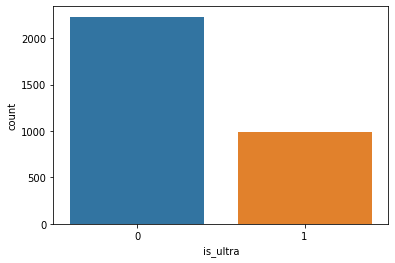

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
sns.countplot(data=df, x='is_ultra')
plt.show()

df['is_ultra'].value_counts()

Данные не имеют пропущенных наблюдений. За исключением бинарной переменной, отвечающей за тариф, характеристики имеют тип `float64`. Поскольку мы работаем с уже обработанным набором данных, дополнительных изменений в исходном наборе проводить не нужно.

Довольно интересная ситуация с расперделением 1 и 0 у таргета. Доля нолей более чем в два раза привышает долю единиц. Это может существенно повлиять на итоговые модели - если в тренировочной выборке будет слишком мало 1, то итоговая модель на тестовых будет плохо их предсказывать. Данный факт различия долей необходимо будет учесть при делении выборки. 

Для упрощения дальнейшей работы разделим наши данные на два блока: целевую переменную и характеристики.

In [7]:
X_numb = df.copy().drop('is_ultra', axis=1)
y = df[['is_ultra']]

Также, поскольку нам предстоит осуществлять обучение моделей, разделим исходную выборку на несколько подгрупп. Для обучения моделей воспользумся тренировочной выборкой, оторая будет составлять 80% от исходных данных. На най же будет осуществляться проверка аccuracy и выбор наилучшей модели. После этого итоговая модель будет проверяться на тренировочной выборке, которая составит 20 % от исходных данных. 

Дополнительно не забудем учесть тот факт, что доли 1 и 0 в исходной выборке не равны. Для того, чтобы отношение долей сохранилось и в подгруппах с данными, передадим параметру stratify значения таргета. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_numb, y, 
                                                  test_size=0.2, 
                                                  stratify = y,
                                                  shuffle = True,
                                                  random_state=12345)

Итак, мы закончили с предворительной работай над исходными данными: кратко изучили их, создали переменные с характеристиками и таргетом, а также разделили нашу выборку на три блока. Теперь можно переходить к непосредственному созданию модели классификации.

In [9]:
print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (2571, 4) (2571, 1)
Размер тестовой выборки: (643, 4) (643, 1)


Как можно заметить, разбиение произошло успешно - количество наблюдений для характеристик и таргета совпадает для каждой из групп данных.

## Моделирование

Данный этап работы посвящен моделированию. В нем мы рассмотрим три модели классификации: логистическую регрессию, решающее дерево и случайный лес. Для каждой из моделей мы попытаемся подобрать такие параметры, благодаря которым будет достигаться наибольшее значение accuracy на валидационной выборке. 

### Логистическая регрессия

Начнем с модели **логистической регрессии**. У данной модели мы рассмотрим два параметра: `solvers` и `penalty`. Первый параметр решает, какой решатель использовать для подбора модели. Второй параметр отвечает за наличие регуляризации, которая помогает снижать переобучение модели посредством наложения штрафов за большие коэффициенты. К сожалению, не каждый вид регуляризации подходит к различным видам решателей, что будет необходимо учесть при обучении модели логистической регрессии.

Итак, обучим модель логистической регрессии, подбирая такие значения параметров `solvers` и `penalty`, чтобы accuracy было максимальным на валидационной выборке.

In [10]:
logit = LogisticRegression(random_state=9)
# Определяем модель для обучения
params_log = {"penalty":["l1","l2"], "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
# Установливаем параметры для перебора
cv_log = GridSearchCV(logit, param_grid=params_log,
                      cv=5, scoring='accuracy')

In [11]:
cv_log.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=9),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [12]:
print('Лучшая логистическая регерссия:', cv_log.best_estimator_)
print('Accuracy:', cv_log.best_score_)

Лучшая логистическая регерссия: LogisticRegression(random_state=9, solver='newton-cg')
Accuracy: 0.7483510256507121


Итак, лучшая модель логистической регрессии имеет следующие параметры: solver='newton-cg' и penalty='l2'. К сожалению, достигаемый показатель accuracy на валидационной выборке не превышает минимальный порог в 0.75. Таким образом, данная модель нам не подходит, а значит мы не будем рассматривать ее в дальнейших пунктах.

### Решающее дерево

Перейдем к следующей модели - решающее дерево. У данной модели мы рассмотрим следующие параметры: `max_depth` и `max_features`. Первый параметр отвечает за глубину дерева, второй характеризует максимальное число признаков, по которым ищется лучшее разбиение в дереве.

In [13]:
decision_tree = DecisionTreeClassifier(random_state=9)
# Задаем модель для обучения
params_tree = {'max_depth': range (1, 4, 1), 'max_features': ['auto', 'sqrt', 'log2'],
               'criterion' :['gini', 'entropy']}
# Устанавливаем параметры для перебора
cv_tree = GridSearchCV(decision_tree, param_grid=params_tree,
                      cv=5, scoring='accuracy')

In [14]:
cv_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=9),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 4),
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring='accuracy')

In [15]:
print('Лучшее дерево решений:', cv_tree.best_estimator_)
print('Accuracy:', cv_tree.best_score_)

Лучшее дерево решений: DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto',
                       random_state=9)
Accuracy: 0.7930860186619318


In [16]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto',
                       random_state=9)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto',
                       random_state=9)

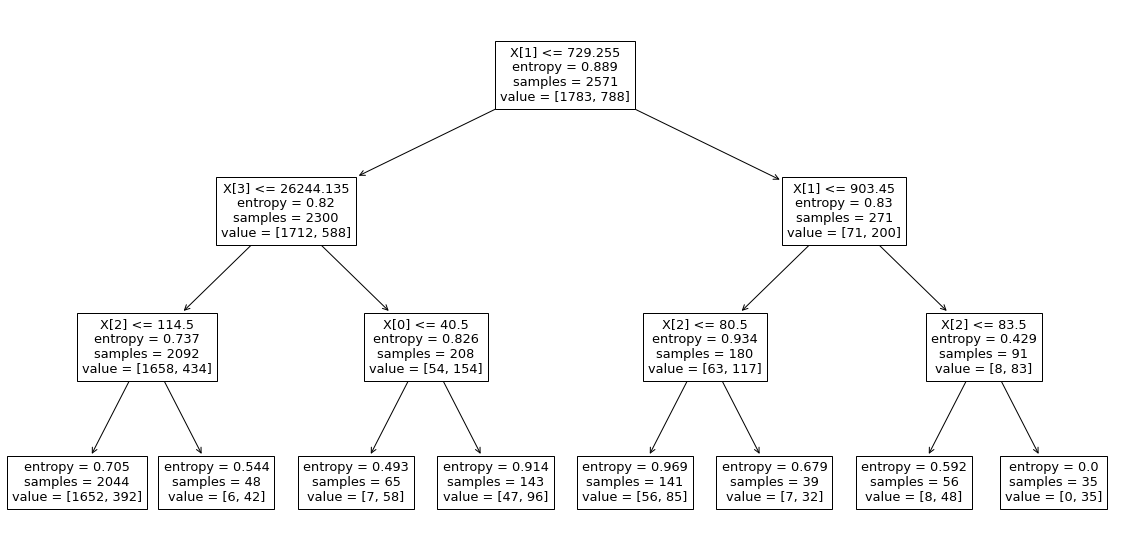

In [17]:
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(decision_tree)
plt.show()

Лучшее дерево решений имеет следующие параметры: criterion='entropy', max_depth=3 и max_features='auto'. На валидационной выборке качество модели превышает минимальный порог, а значит данная модель может быть рассмотрена в качестве одной из исходных. Окончательный вывод о лучшей модели можно будет сделать после обучения последней из оставшихся моделей.

### Случайный лес

Наконец, перейдем к последней модели - случайному лесу. У данной модели мы рассмотрим следующие параметры: `max_depth`, `max_features` и `n_estimators`. Первые два мы уже рассматривали при построении дерева решений, так что подробнее расскажем только о последнем. Он определяет общее число деревьев, которые построит наша модель.

In [19]:
random_forest = RandomForestClassifier(random_state=9)
# Задаем модель для обучения
params_forest = {'max_depth': range (1, 4, 1), 'max_features': ['auto', 'sqrt', 'log2'],
               'criterion' :['gini', 'entropy'], 'n_estimators': range(50, 100, 10)}
# Указываем параметры для перебора
cv_forest = GridSearchCV(random_forest, param_grid=params_forest,
                      cv=5, scoring='accuracy')

In [20]:
cv_forest.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=9),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 4),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(50, 100, 10)},
             scoring='accuracy')

In [21]:
print('Лучший случайный лес:', cv_forest.best_estimator_)
print('Accuracy:', cv_forest.best_score_)

Лучший случайный лес: RandomForestClassifier(max_depth=3, n_estimators=70, random_state=9)
Accuracy: 0.7954191379245211


Лучшая модель случайного леса имеет следующие параметры: max_depth=3, n_estimators=70 и criterion=gini. Показатель качества данной модели также превышает попроговое значение. Более того, качество данной модели превосходит качество дерева решений, на основе чего мы принимает модель случайного леса в качестве итоговой модели. 

## Проверка качества

На данном этапе рассмотрим, как построенная нами модель, которую мы выбрали в качестве итоговой, справляется с предказаниями на тестовых данных. Напомним, что по итогу предыдущего этапа работы итоговой моделью была выбрана модель случайного леса со следующими параметрами: max_depth=3, n_estimators=70 и criterion=gini.

In [22]:
print('Качество случайного леса на тестовой выборке', accuracy_score(y_test, cv_forest.predict(X_test)))

Качество случайного леса на тестовой выборке 0.7993779160186625


Модель случайного леса показала неплохое значение критерия качества. Как минимум, критерий качества не снизился по сравнению с аналогичным показателем для тренировочной выборки, но и даже немного возрос. Это позволяет сделать вывод о том, что наша модель сильно не переобучилась. 

## Проверка на вменяемость

Дополниетльно проведем проверку нашей итоговой модели на вменяемость. Для этого сравним ее значение качества с аналогичным показателем еще двух моделей: случайной и дамми. Качество случайной модели составляет 0.5, а значит наша итоговая модель как минимум лучше модели, выдающей предсказания случайно.

Для сравнения нашей итоговой модели с дамми, построим вторую, предворительно подобрав ей лучшие параметры.

In [23]:
best_dummy_model = None
best_dummy_result = 0
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf = dummy_clf.fit(X_train, y_train)
print('Качество дамми модели на тренировочной выборке', dummy_clf.score(X_train, y_train))
print('Качество дамми модели на тестовой выборке', dummy_clf.score(X_test, y_test))

Качество дамми модели на тренировочной выборке 0.6935044729677169
Качество дамми модели на тестовой выборке 0.6936236391912908


Как можно заметить, качество дамми модели также меньше аналогичных показателей у итоговой модели. Таким образом, мы можем с увереностью назвать выбранную нами итоговую модель вменяемой. 

## Заключение

Нами была проделана работа по созданию модели, которая будет осуществлять подбор наиболее оптимального для пользователя тарифа. Всего нами было рассмотрено три модели: логистическая регрессия, решающее дерево и случайный лес. Для каждой из них мы попытались подобрать наиболее оптимальные параметры, которые бы позволили достичь наибольшее значение accuracy на валидационной выборке. По итогу этапа моделирования только две модели смогли преодолеть минимальный порог по качеству: случайный лес и решающее дерево. Модель логистической регрессии не смогла преодолеть порог показателя accuracy в 0.75 на валидационной выборке.

В качестве итоговой была вбрана модель случайного леса со следующими параметрами: max_depth=3, n_estimators=70 и criterion=gini. Именно данная модель показала лучший результат на тренировочной выборке. 

После этого мы проверили качество нашей итоговой модели на тестовой выборке. Качество нашей итоговой модели еще не идеальное, однако нам удалось получить модель без серьезного переобучения - качество на тесте не упало по сравнению с тренировочным качеством. 

Также дополнительно мы провели проверку нашей итоговой модели на вменяемойсть. Качество итоговой модели оказалось выше качества случайной и дамми моделей, что позволило нам следать вывод о том, что выбраная нами модель является вменяемой. 